オーバーサンプリングを行い、クラスの不均衡を解消した状態で再び分類器によるモデルを構築します。
前半はチューニング前の分析、後半はチューニング後のパラメータを設定し直した分類器でモデルを再構築しています。以下のリストはコードの概要
1. データの前処理・オーバーサンプリング
2. 必要な機械学習のライブラリをインポート
3. 分類器の定義(チューニング前のデフォルト値)
4. K分割交差検証なしの状態でのROC曲線、AUCのスコア
5. 交差検証なしの場合での正解率
6. 交差検証なしの場合での再現率
7. 層化K分割交差検証を使った状態でのROC曲線、AUCのスコア
8. 交差検証を行った状態での正解率
9. 交差検証を行った状態での再現率
10. ハイパーパラメータでチューニング結果が最良だったものを分類器に設定し、再定義
11. コード10番で定義したものをもとに層化K分割交差検証を行い、ROC曲線とAUCを求める
12. 正解率を求める
13. 再現率を求める
14. 正解率とAUCのスコアの合計が高かった分類器上位3つを選んで多数決分類器を定義
15. 多数決分類器と他の3つの分類器を使ったROC曲線とAUCを計算。
16. 多数決分類器・他3つの分類器の正解率を求める

結論:サンプリング、分割検証による性能の向上がとくに著しい。K分割交差検証はアンサンブル分類器に、サンプリングはどの分類器にも貢献。サンプリングを行ったことでAUCや正解率を正常に使って評価することができるようになった。チューニングを行うとやや性能は改善された。多数決分類器の実装は元々高性能な分類器を組み合わせれば盤石のモデルとなることが分かった。

In [1]:
#データの前処理・オーバーサンプリング
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df=pd.read_csv("train.csv")
#データのエンコーディング。（IDは不要と考え、予め抜いています）
#数値データ以外のカラムは順序特徴量として扱えるような根拠となるデータが無かったので、全て名義特徴量として扱っています。
#one-hotエンコーディングでデータ処理を行いました。多重共線性を抑えるため、エンコーディングした列の1つを削除しています。(drop_first=True)
df_dummy=pd.get_dummies(df[["job","marital","education",
                            "default","housing","loan",
                            "contact","month","poutcome","subscribed",
                            "age","balance","day","previous",
                            "duration","campaign","pdays"]],drop_first=True)
X,y=df_dummy.iloc[:,0:42],df_dummy.iloc[:,42].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
#データの標準化
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)
#データのオーバーサンプリング。SMOTEを使用しています。
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
sm = SMOTE(random_state=2)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train.ravel())

In [2]:
#機械学習に必要な分類器や、K分割交差検証などのツールの呼び出し
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import recall_score,classification_report

In [3]:
#分類器の設定：チューニング前なので全てデフォルトで設定しています。
log=LogisticRegression(random_state=1)
dt=DecisionTreeClassifier(random_state=1)
knn=KNeighborsClassifier()
svc=SVC(probability=True)
rfc=RandomForestClassifier(random_state=1)
ada=AdaBoostClassifier(base_estimator=dt,random_state=1)
gb=GradientBoostingClassifier(random_state=1)
all_clf=[log,dt,knn,svc,rfc,ada,gb]
clf_labels=["LogisticRegression","DecisionTree","KNeighbor",
            "SVC","RandomForest","AdaBoost","GradientBoost"]

In [ ]:
#結果ROC_AUCのプロット。K分割交差検証なしの状態で、性能を見ています。
fig=plt.figure(figsize=(6,4))
colors=["blue","green","red","purple","orange","cyan","olive"]
for clf,label,clr in zip(all_clf,clf_labels,colors):
  y_pred=clf.fit(X_train_res,y_train_res).predict_proba(X_test)[:,1]
  fpr,tpr,thresholds=roc_curve(y_true=y_test,y_score=y_pred)
  roc_auc=auc(x=fpr,y=tpr)
  plt.plot(fpr,tpr,color=clr,label="%s(auc=%0.2f)"%(label,roc_auc))
plt.legend(loc="lower right")
plt.plot([0,0,1],[0,1,1],
         linestyle=":",color="black",label="Perfect Perfomance")
plt.plot([0,1],[0,1],linestyle="--",color="gray",linewidth=2,label="Random Guessing")
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show
#出力結果から、この時点で最も優秀なのはロジスティックとSVC。auc=0.91
#層化K分割検証も行って、性能を測定します。

In [ ]:
#交差検証なしの場合でのaccuracyを見ています。
for clf,label in zip(all_clf,clf_labels):
  clf.fit(X_train_res,y_train_res)
  print("accuracy: %0.2f [%s]" % (clf.score(X_test,y_test),label) ) #小数点第二位まで計算
#出力結果から、交差検証をしない場合、正解率がかなり低くなってしまう（アンサンブルは特に）ことが分かりました。

accuracy: 0.85 [Logistic Regression]
accuracy: 0.74 [DecisionTree]
accuracy: 0.83 [KNeighbor]
accuracy: 0.86 [SVC]
accuracy: 0.66 [RandomForest]


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


accuracy: 0.74 [AdaBoost]
accuracy: 0.35 [GradientBoost]


In [10]:
#交差検証なし　recallスコア
from sklearn.metrics import recall_score
for clf,label in zip(all_clf,clf_labels):
  clf.fit(X_train_res,y_train_res)
  y_pred=clf.predict(X_test)
  scores=recall_score(y_test,y_pred)
  print("recall: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

recall: 0.81(+/- 0.00) [LogisticRegression]
recall: 0.79(+/- 0.00) [DecisionTree]
recall: 0.68(+/- 0.00) [KNeighbor]
recall: 0.77(+/- 0.00) [SVC]
recall: 0.93(+/- 0.00) [RandomForest]


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


recall: 0.81(+/- 0.00) [AdaBoost]
recall: 0.99(+/- 0.00) [GradientBoost]


In [ ]:
#層化K分割交差検証を行った状態で、ROC曲線をプロット
from sklearn.model_selection import StratifiedKFold
from scipy import interp
cv=list(StratifiedKFold(n_splits=5).split(X_train_res,y_train_res))
fig = plt.figure(figsize=(7,5))
#logistic
mean_fpr_log=np.linspace(0,1,100)
mean_tpr_log= 0.0
for i,(train, test) in enumerate(cv):
  probas = log.fit(X_train_res[train], y_train_res[train]).predict_proba(X_train_res[test])
  fpr_log,tpr_log,thresholds_log=roc_curve(y_train_res[test], probas[:, 1], pos_label=1)
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
  mean_tpr_log[0]=0
  roc_auc_log=auc(fpr_log, tpr_log)
mean_tpr_log=mean_tpr_log/len(cv)
mean_auc_log=auc(mean_fpr_log, mean_tpr_log)
plt.plot(mean_fpr_log, mean_tpr_log,color="blue",
         label="%s(auc=%0.2f)"%(clf_labels[0],mean_auc_log))
#decisiontree
mean_fpr_dt=np.linspace(0,1,100)
mean_tpr_dt=0.0
for i,(train, test) in enumerate(cv):
  probas=dt.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_dt,tpr_dt,thresholds_dt=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_dt+=interp(mean_fpr_dt,fpr_dt,tpr_dt)
  mean_tpr_dt[0]=0
  roc_auc_dt=auc(fpr_dt,tpr_dt)
mean_tpr_dt=mean_tpr_dt/len(cv)
mean_auc_dt=auc(mean_fpr_dt,mean_tpr_dt)
plt.plot(mean_fpr_dt,mean_tpr_dt,color="green",label="%s(auc=%0.2f)"%(clf_labels[1],mean_auc_dt))
#kneighbor
mean_fpr_knn=np.linspace(0,1,100)
mean_tpr_knn=0.0
for i,(train, test) in enumerate(cv):
  probas=knn.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_knn,tpr_knn,thresholds_knn=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
  mean_tpr_knn[0]=0
  roc_auc_knn=auc(fpr_knn, tpr_knn)
mean_tpr_knn=mean_tpr_knn/len(cv)
mean_auc_knn=auc(mean_fpr_knn,mean_tpr_knn)
plt.plot(mean_fpr_knn,mean_tpr_knn,color="red",
         label="%s(auc=%0.2f)"%(clf_labels[2],mean_auc_knn))
#SVC
mean_fpr_svc=np.linspace(0,1,100)
mean_tpr_svc=0.0
for i,(train, test) in enumerate(cv):
  probas=svc.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_svc,tpr_svc,thresholds_svc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_svc+=interp(mean_fpr_svc,fpr_svc,tpr_svc)
  mean_tpr_svc[0]=0
  roc_auc_svc=auc(fpr_svc,tpr_svc)
mean_tpr_svc=mean_tpr_svc/len(cv)
mean_auc_svc=auc(mean_fpr_svc,mean_tpr_svc)
plt.plot(mean_fpr_svc,mean_tpr_svc,color="purple",
         label="%s(auc=%0.2f)"%(clf_labels[3],mean_auc_svc))
#randomforest
mean_fpr_rfc=np.linspace(0,1,100)
mean_tpr_rfc=0.0
for i,(train, test) in enumerate(cv):
  probas=rfc.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_rfc,tpr_rfc,thresholds_rfc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_rfc+=interp(mean_fpr_rfc,fpr_rfc,tpr_rfc)
  mean_tpr_rfc[0]=0
  roc_auc_rfc=auc(fpr_rfc,tpr_rfc)
mean_tpr_rfc=mean_tpr_rfc/len(cv)
mean_auc_rfc=auc(mean_fpr_rfc,mean_tpr_rfc)
plt.plot(mean_fpr_rfc,mean_tpr_rfc,color="orange",
         label="%s(auc=%0.2f)"%(clf_labels[4],mean_auc_rfc))
#adaboost
mean_fpr_ada=np.linspace(0,1,100)
mean_tpr_ada=0.0
for i,(train,test) in enumerate(cv):
  probas=ada.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_ada,tpr_ada,thresholds_ada=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_ada+=interp(mean_fpr_ada,fpr_ada,tpr_ada)
  mean_tpr_ada[0]=0
  roc_auc_ada=auc(fpr_ada,tpr_ada)
mean_tpr_ada=mean_tpr_ada/len(cv)
mean_auc_ada=auc(mean_fpr_ada,mean_tpr_ada)
plt.plot(mean_fpr_ada,mean_tpr_ada,color="cyan",
         label="%s(auc=%0.2f)"%(clf_labels[5],mean_auc_ada))
#gradientboost
mean_fpr_gb=np.linspace(0,1,100)
mean_tpr_gb=0.0
for i,(train, test) in enumerate(cv):
  probas=gb.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_gb,tpr_gb,thresholds_gb=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_gb+=interp(mean_fpr_gb,fpr_gb,tpr_gb)
  mean_tpr_gb[0]=0
  roc_auc_gb=auc(fpr_gb,tpr_gb)
mean_tpr_gb=mean_tpr_gb/len(cv)
mean_auc_gb=auc(mean_fpr_gb,mean_tpr_gb)
plt.plot(mean_fpr_gb,mean_tpr_gb,color="olive",
         label="%s(auc=%0.2f)"%(clf_labels[6],mean_auc_gb))
# ランダムチョイスの結果をプロット
plt.plot([0, 1], [0, 1],linestyle='--', color=(0.6,0.6,0.6),label='random guessing')
#完璧な予測をした場合の結果をプロット
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()
#精度がかなり良くなっていることが分かります。
#randomforestは0.99にまでAUCが改善されていることが分かります

In [ ]:
#accuracyのスコア　交差検証あり
for clf,label in zip(all_clf,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="accuracy")
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

In [ ]:
#recallのスコア　交差検証あり
for clf,label in zip(all_clf,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="recall")
  print("recall: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

In [3]:
#チューニング結果をまとめてグラフにプロット
#分類器の定義：チューニング結果から、最良と思われるパラメータを設定しています。
log_best=LogisticRegression(random_state=1,
                            C=0.01,solver="liblinear",
                            penalty="l2")
dt_best=DecisionTreeClassifier(random_state=1,
                               criterion="entropy",
                               max_depth=None,
                               max_features="auto")
knn_best=KNeighborsClassifier(n_neighbors=1,
                              weights="uniform")
svc_best=SVC(probability=True,
             kernel="rbf",
             C=1)
rfc_best=RandomForestClassifier(random_state=1,
                                criterion="entropy",
                                max_depth=None,
                                max_features="log2",
                                n_estimators=200)
ada_best=AdaBoostClassifier(base_estimator=dt_best,
                            random_state=1,
                            learning_rate=1,
                            n_estimators=200)
gb_best=GradientBoostingClassifier(random_state=1,
                                   max_depth=9,
                                   learning_rate=0.1,
                                   n_estimators=100)
clf_best=[log_best,dt_best,knn_best,svc_best,rfc_best,ada_best,gb_best]
clf_labels=["Logistic Regression","DecisionTree","KNeighbor",
            "SVC","RandomForest","AdaBoost","GradientBoost"]

In [ ]:
#チューニング結果を基に、再びグラフをプロット
from sklearn.model_selection import StratifiedKFold
from scipy import interp
cv=list(StratifiedKFold(n_splits=5).split(X_train_res,y_train_res))
fig=plt.figure(figsize=(6,4))
#logistic
mean_fpr_log=np.linspace(0,1,100)
mean_tpr_log= 0.0
for i,(train, test) in enumerate(cv):
  probas=log_best.fit(X_train_res[train], y_train_res[train]).predict_proba(X_train_res[test])
  fpr_log,tpr_log,thresholds_log=roc_curve(y_train_res[test], probas[:, 1], pos_label=1)
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
  mean_tpr_log[0]=0
  roc_auc_log=auc(fpr_log, tpr_log)
mean_tpr_log=mean_tpr_log/len(cv)
mean_auc_log=auc(mean_fpr_log, mean_tpr_log)
plt.plot(mean_fpr_log, mean_tpr_log,color="blue",
         label="%s(auc=%0.2f)"%(clf_labels[0],mean_auc_log))
#decisiontree
mean_fpr_dt=np.linspace(0,1,100)
mean_tpr_dt=0.0
for i,(train, test) in enumerate(cv):
  probas=dt_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_dt,tpr_dt,thresholds_dt=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_dt+=interp(mean_fpr_dt,fpr_dt,tpr_dt)
  mean_tpr_dt[0]=0
  roc_auc_dt=auc(fpr_dt,tpr_dt)
mean_tpr_dt=mean_tpr_dt/len(cv)
mean_auc_dt=auc(mean_fpr_dt,mean_tpr_dt)
plt.plot(mean_fpr_dt,mean_tpr_dt,color="green",label="%s(auc=%0.2f)"%(clf_labels[1],mean_auc_dt))
#kneighbor
mean_fpr_knn=np.linspace(0,1,100)
mean_tpr_knn=0.0
for i,(train, test) in enumerate(cv):
  probas=knn_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_knn,tpr_knn,thresholds_knn=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
  mean_tpr_knn[0]=0
  roc_auc_knn=auc(fpr_knn, tpr_knn)
mean_tpr_knn=mean_tpr_knn/len(cv)
mean_auc_knn=auc(mean_fpr_knn,mean_tpr_knn)
plt.plot(mean_fpr_knn,mean_tpr_knn,color="red",
         label="%s(auc=%0.2f)"%(clf_labels[2],mean_auc_knn))
#svc
mean_fpr_svc=np.linspace(0,1,100)
mean_tpr_svc=0.0
for i,(train, test) in enumerate(cv):
  probas=svc_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_svc,tpr_svc,thresholds_svc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_svc+=interp(mean_fpr_svc,fpr_svc,tpr_svc)
  mean_tpr_svc[0]=0
  roc_auc_svc=auc(fpr_svc,tpr_svc)
mean_tpr_svc=mean_tpr_svc/len(cv)
mean_auc_svc=auc(mean_fpr_svc,mean_tpr_svc)
plt.plot(mean_fpr_svc,mean_tpr_svc,color="purple",
         label="%s(auc=%0.2f)"%(clf_labels[3],mean_auc_svc))
#randomforest
mean_fpr_rfc=np.linspace(0,1,100)
mean_tpr_rfc=0.0
for i,(train, test) in enumerate(cv):
  probas=rfc_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_rfc,tpr_rfc,thresholds_rfc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_rfc+=interp(mean_fpr_rfc,fpr_rfc,tpr_rfc)
  mean_tpr_rfc[0]=0
  roc_auc_rfc=auc(fpr_rfc,tpr_rfc)
mean_tpr_rfc=mean_tpr_rfc/len(cv)
mean_auc_rfc=auc(mean_fpr_rfc,mean_tpr_rfc)
plt.plot(mean_fpr_rfc,mean_tpr_rfc,color="orange",
         label="%s(auc=%0.2f)"%(clf_labels[4],mean_auc_rfc))
#adaboost
mean_fpr_ada=np.linspace(0,1,100)
mean_tpr_ada=0.0
for i,(train,test) in enumerate(cv):
  probas=ada_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_ada,tpr_ada,thresholds_ada=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_ada+=interp(mean_fpr_ada,fpr_ada,tpr_ada)
  mean_tpr_ada[0]=0
  roc_auc_ada=auc(fpr_ada,tpr_ada)
mean_tpr_ada=mean_tpr_ada/len(cv)
mean_auc_ada=auc(mean_fpr_ada,mean_tpr_ada)
plt.plot(mean_fpr_ada,mean_tpr_ada,color="cyan",
         label="%s(auc=%0.2f)"%(clf_labels[5],mean_auc_ada))
#gradientboost
mean_fpr_gb=np.linspace(0,1,100)
mean_tpr_gb=0.0
for i,(train, test) in enumerate(cv):
  probas=gb_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_gb,tpr_gb,thresholds_gb=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_gb+=interp(mean_fpr_gb,fpr_gb,tpr_gb)
  mean_tpr_gb[0]=0
  roc_auc_gb=auc(fpr_gb,tpr_gb)
mean_tpr_gb=mean_tpr_gb/len(cv)
mean_auc_gb=auc(mean_fpr_gb,mean_tpr_gb)
plt.plot(mean_fpr_gb,mean_tpr_gb,color="olive",
         label="%s(auc=%0.2f)"%(clf_labels[6],mean_auc_gb))
# 当て推量をプロット
plt.plot([0, 1], [0, 1],linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()
#AUCはわずかに上昇しています。
#ただ、チューニング前よりスコアが下がったものもありました。

In [6]:
#accuracy の平均を見てみる（チューニング後の結果）
for clf,label in zip(clf_best,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="accuracy")
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
#votingはAUCの値とaccuracyの値の合計が大きいもの3つをピックアップし、多数決分類器を定義することにしました。

accuracy: 0.85(+/- 0.01) [Logistic Regression]


/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9

accuracy: 0.90(+/- 0.04) [DecisionTree]
accuracy: 0.95(+/- 0.00) [KNeighbor]
accuracy: 0.91(+/- 0.01) [SVC]
accuracy: 0.95(+/- 0.04) [RandomForest]


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


accuracy: 0.90(+/- 0.04) [AdaBoost]
accuracy: 0.93(+/- 0.07) [GradientBoost]


In [6]:
for clf,label in zip(clf_best,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="recall")
  print("recall: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

recall: 0.85(+/- 0.02) [Logistic Regression]


/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9

recall: 0.90(+/- 0.10) [DecisionTree]
recall: 0.99(+/- 0.00) [KNeighbor]
recall: 0.95(+/- 0.02) [SVC]
recall: 0.96(+/- 0.08) [RandomForest]


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


recall: 0.91(+/- 0.10) [AdaBoost]
recall: 0.91(+/- 0.16) [GradientBoost]


In [4]:
#多数決分類器の定義
from sklearn.ensemble import VotingClassifier
estimator = [('knn',knn_best),
             ('rfc',rfc_best),
             ('gb', gb_best)]
vt=VotingClassifier(estimators=estimator, voting='soft')

<ipython-input-5-c863a3ee6f88>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-5-c863a3ee6f88>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-5-c863a3ee6f88>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-5-c863a3ee6f88>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-5-c863a3ee6f88>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-5-c86

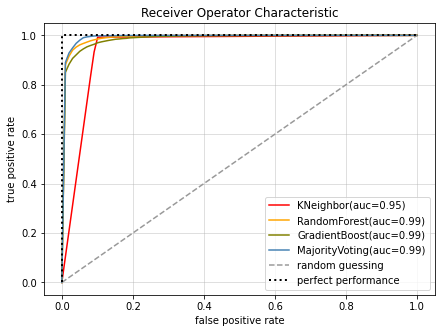

In [5]:
#majorityvoting,randomforest,knn,gradientboostのROC曲線をプロット
#
from sklearn.model_selection import StratifiedKFold
from scipy import interp
clf_labels=["KNeighbor","RandomForest","GradientBoost","MajorityVoting"]
cv=list(StratifiedKFold(n_splits=5).split(X_train_res,y_train_res))
fig = plt.figure(figsize=(7,5))
#kneighbor
mean_fpr_knn=np.linspace(0,1,100)
mean_tpr_knn=0.0
for i,(train,test) in enumerate(cv):
  probas=knn_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_knn,tpr_knn,thresholds_knn=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
  mean_tpr_knn[0]=0
  roc_auc_knn=auc(fpr_knn, tpr_knn)
mean_tpr_knn=mean_tpr_knn/len(cv)
mean_auc_knn=auc(mean_fpr_knn,mean_tpr_knn)
plt.plot(mean_fpr_knn,mean_tpr_knn,color="red",
         label="%s(auc=%0.2f)"%(clf_labels[0],mean_auc_knn))
#randomforest
mean_fpr_rfc=np.linspace(0,1,100)
mean_tpr_rfc=0.0
for i,(train, test) in enumerate(cv):
  probas=rfc_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_rfc,tpr_rfc,thresholds_rfc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_rfc+=interp(mean_fpr_rfc,fpr_rfc,tpr_rfc)
  mean_tpr_rfc[0]=0
  roc_auc_rfc=auc(fpr_rfc,tpr_rfc)
mean_tpr_rfc=mean_tpr_rfc/len(cv)
mean_auc_rfc=auc(mean_fpr_rfc,mean_tpr_rfc)
plt.plot(mean_fpr_rfc,mean_tpr_rfc,color="orange",
         label="%s(auc=%0.2f)"%(clf_labels[1],mean_auc_rfc))
#gradientboost
mean_fpr_gb=np.linspace(0,1,100)
mean_tpr_gb=0.0
for i,(train,test) in enumerate(cv):
  probas=gb_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_gb,tpr_gb,thresholds_gb=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_gb+=interp(mean_fpr_gb,fpr_gb,tpr_gb)
  mean_tpr_gb[0]=0
  roc_auc_gb=auc(fpr_gb,tpr_gb)
mean_tpr_gb=mean_tpr_gb/len(cv)
mean_auc_gb=auc(mean_fpr_gb,mean_tpr_gb)
plt.plot(mean_fpr_gb,mean_tpr_gb,color="olive",
         label="%s(auc=%0.2f)"%(clf_labels[2],mean_auc_gb))
#majorityvoting
mean_fpr_vt=np.linspace(0,1,100)
mean_tpr_vt=0.0
for i,(train,test) in enumerate(cv):
  probas=vt.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_vt,tpr_vt,thresholds_vt=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_vt+=interp(mean_fpr_vt,fpr_vt,tpr_vt)
  mean_tpr_vt[0]=0
  roc_auc_vt=auc(fpr_vt,tpr_vt)
mean_tpr_vt=mean_tpr_vt/len(cv)
mean_auc_vt=auc(mean_fpr_vt,mean_tpr_vt)
plt.plot(mean_fpr_vt,mean_tpr_vt,color="steelblue",
         label="%s(auc=%0.2f)"%(clf_labels[3],mean_auc_vt))
plt.plot([0, 1], [0, 1],linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
clf_labels=["KNeighbor","RandomForest","GradientBoost","MajorityVoting"]
for clf,label in zip(clf_best,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="accuracy")
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

accuracy: 0.85(+/- 0.01) [KNeighbor]
accuracy: 0.90(+/- 0.04) [RandomForest]
accuracy: 0.95(+/- 0.00) [GradientBoost]
accuracy: 0.91(+/- 0.01) [MajorityVoting]
